In [10]:
import networkx as nx
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
import glob

In [134]:
lattice = nx.lattice.grid_2d_graph(n=10, m=10, periodic=True)
lattice = lattice

In [135]:
def to_gset(gfile: str, g: nx.Graph):
    with open(gfile, mode='w') as gset:
        gset.write('{} {}\n'.format(g.number_of_nodes(), g.number_of_edges()))
        edgelist = g.edges()
        n = g.number_of_nodes()
        for u,v in g.edges():
            src = u[0] * 10 + u[1]
            dst = v[0] * 10 + v[1]
            gset.write('{} {} 1\n'.format(src, dst)) 

In [136]:
to_gset('../lattice_2d.gset', lattice)

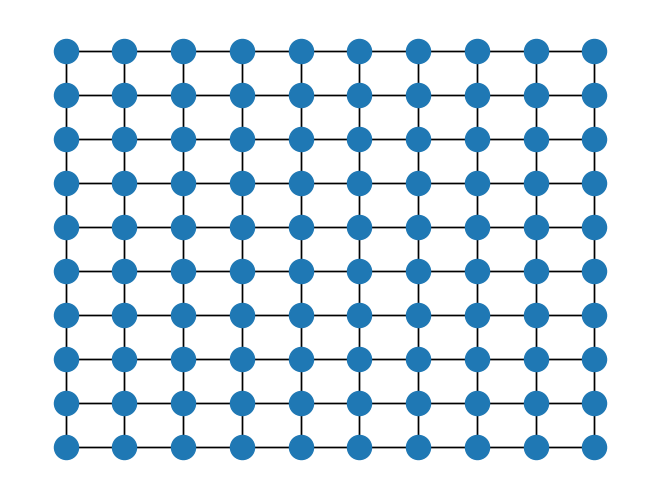

In [141]:
layout = dict([i, i] for i in lattice.nodes)
nx.draw(lattice, layout)
# print(lattice.nodes)

In [143]:
files = [os.path.abspath('../data/'+i) for i in os.listdir('../data')]
dflist = [pd.read_csv(i) for i in files]
df = pd.concat(dflist)
df

FileNotFoundError: [Errno 2] No such file or directory: '../data'

In [51]:
mean_df = df.groupby('beta').mean().reset_index()

In [52]:
mean_df['$\sqrt{M}$'] = np.sqrt(mean_df['M'])

In [142]:
ax=sns.lineplot(data=mean_df, x='beta', y='$\sqrt{M}$')
ax.set_ylabel('RMS')

NameError: name 'mean_df' is not defined

<AxesSubplot: xlabel='beta', ylabel='ene'>

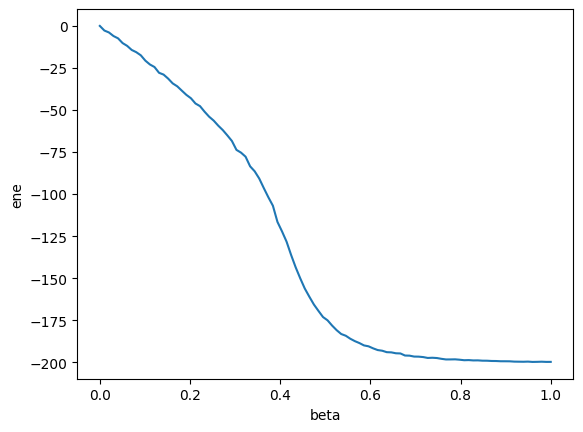

In [55]:
sns.lineplot(data=mean_df, x='beta', y='ene')

In [56]:
# df.to_csv('full_active_2d.csv', index=False)

In [27]:
df40_5 = pd.read_csv('../rank40.csv')
df40_5['Active Epochs'] = 5
df40_5['Active'] = 40
df40_100 = pd.read_csv('../rank40_100.csv')
df40_100['Active Epochs'] = 100
df40_100['Active'] = 40

df60_5 = pd.read_csv('../rank60.csv')
df60_5['Active Epochs'] = 5
df60_5['Active'] = 60
df60_100 = pd.read_csv('../rank60_100.csv')
df60_100['Active Epochs'] = 100
df60_100['Active'] = 60

df80_5 = pd.read_csv('../rank80.csv')
df80_5['Active Epochs'] = 5
df80_5['Active'] = 80
df80_100 = pd.read_csv('../rank80_100.csv')
df80_100['Active Epochs'] = 100
df80_100['Active'] = 80

df100 = pd.read_csv('../rank100.csv')
df100 = df100.rename(columns=dict([(i, i+'_100') for i in df100.columns if i!='beta']))
df100['Active Epochs'] = 1
df100['Active'] = 100

In [77]:
comp_df = pd.concat([df40_5, df40_100,
                     df60_5, df60_100,
                     df80_5, df80_100,
                     df100]).reset_index().drop(columns=['index'])
hue = comp_df['Active'].astype(str) + ', ' + comp_df['Active Epochs'].astype(str)

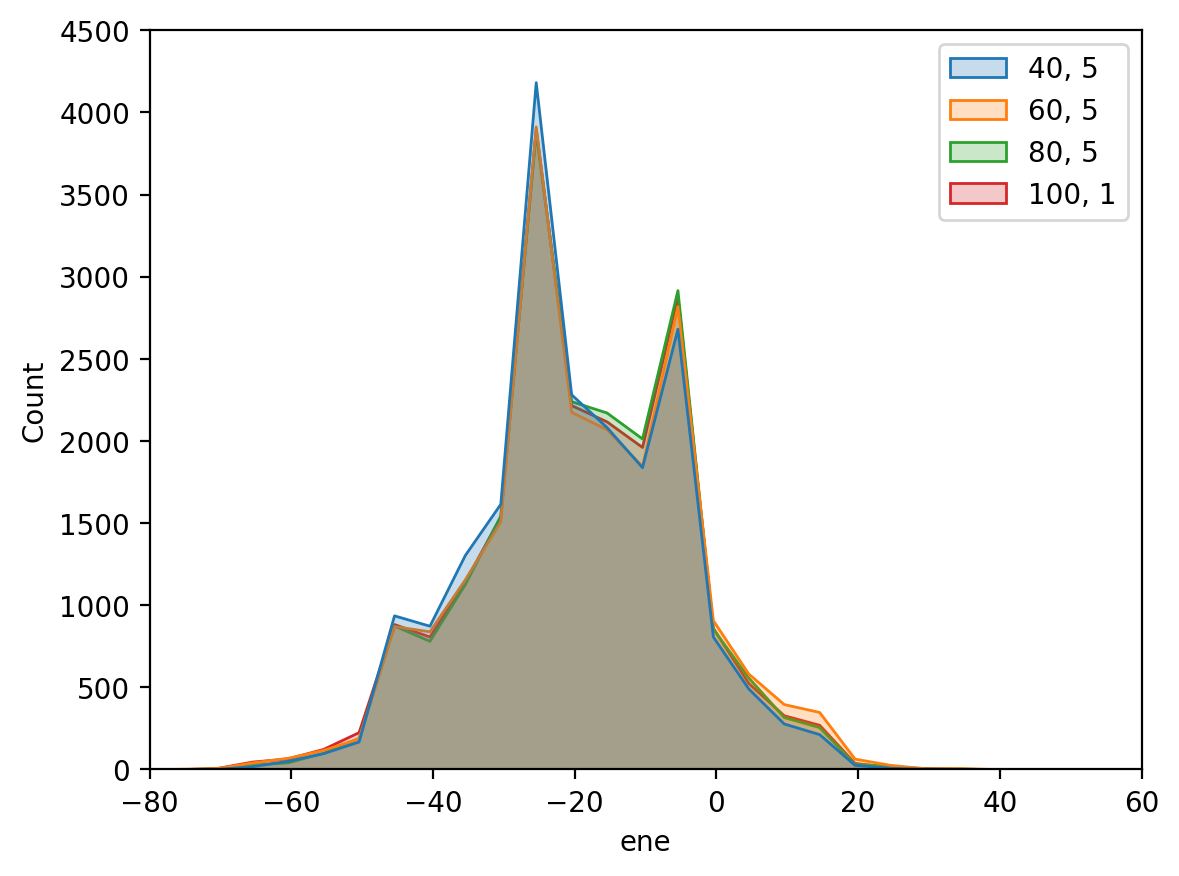

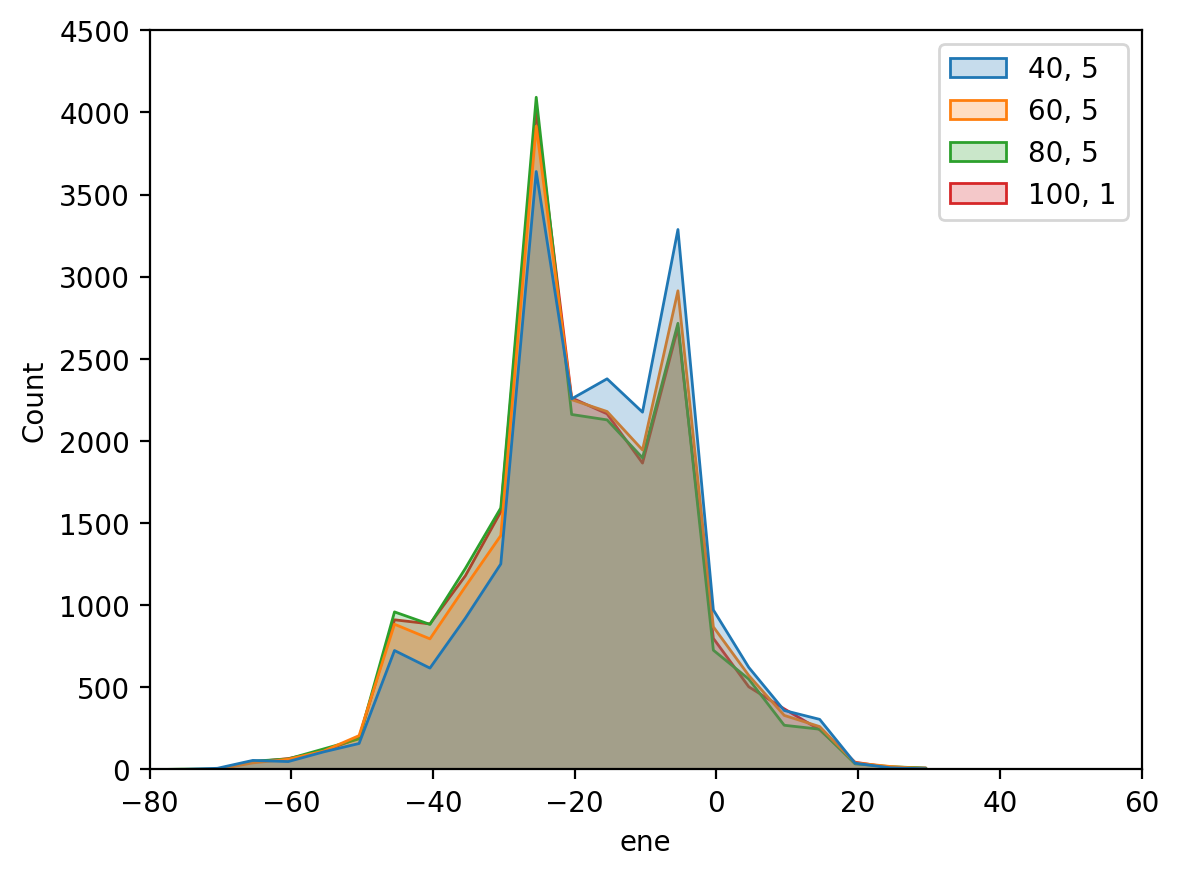

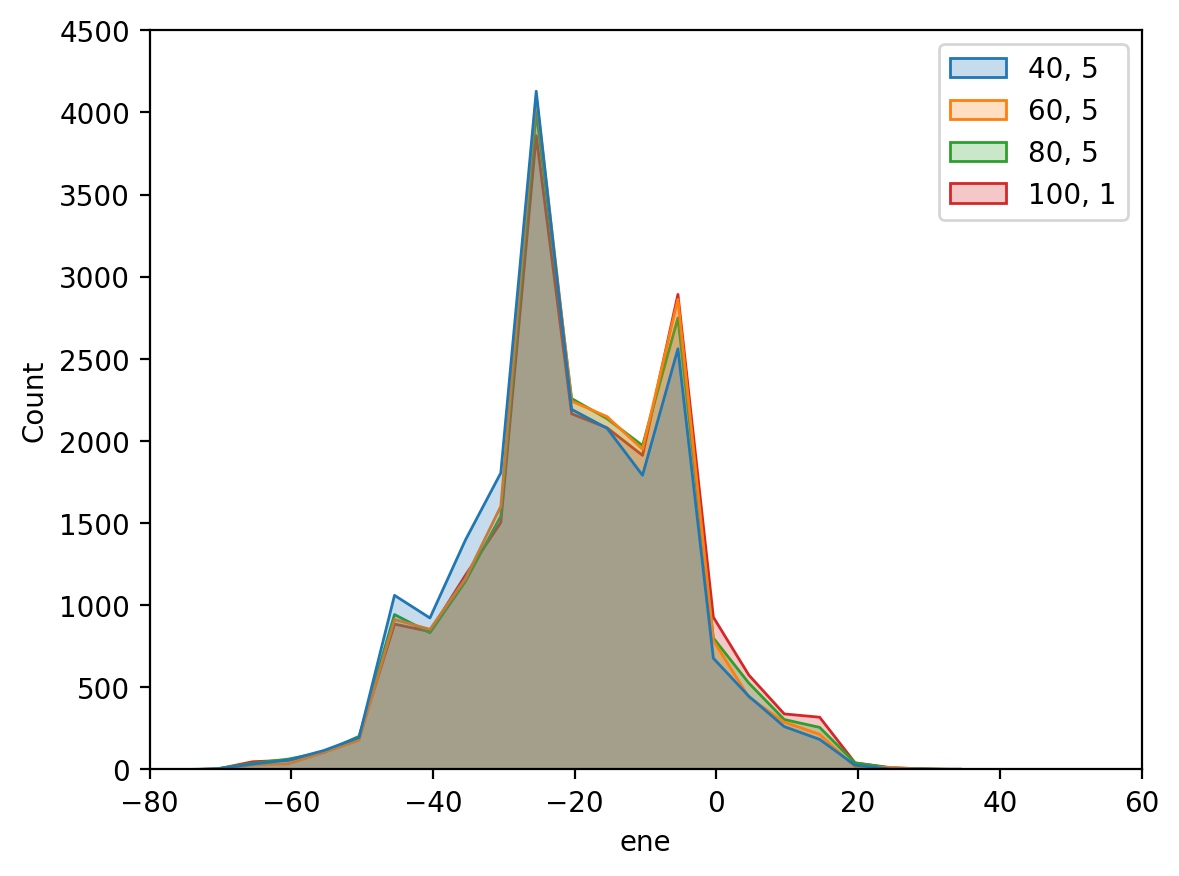

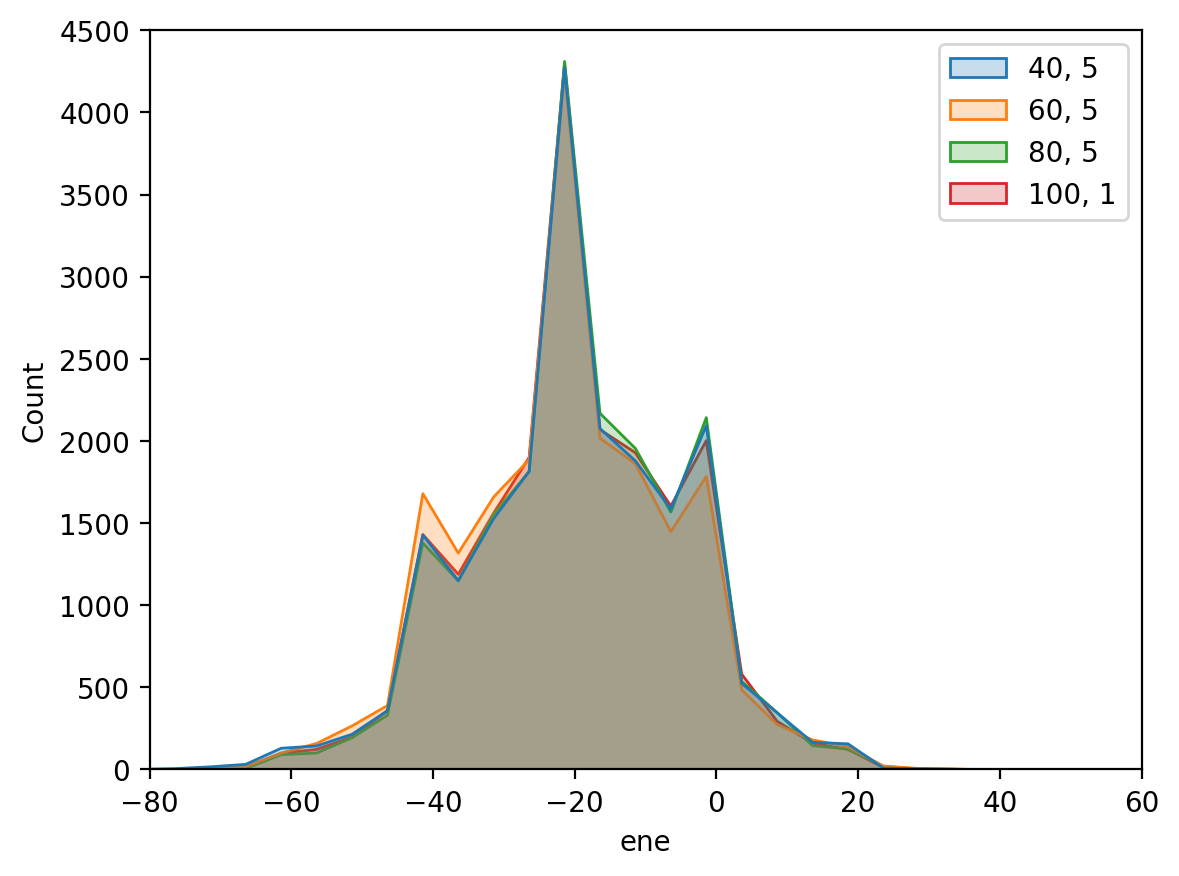

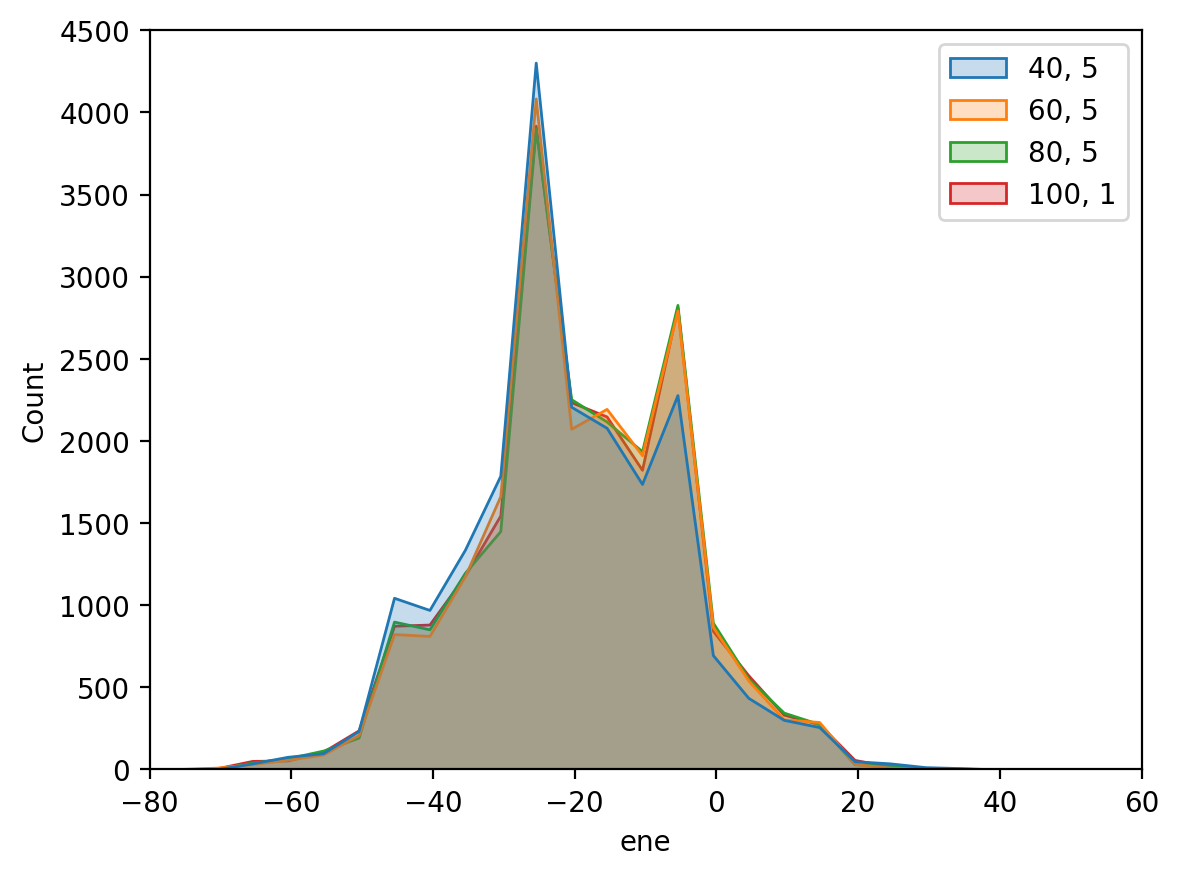

In [78]:
tuplist = [
    (1, 100),
    (5, 40),
    (100, 40),
    (5, 60),
    (100, 60),
    (5, 80),
    (100, 80)
]
# for ae, a in tuplist:
    # qdf = comp_df.query(f'`Active Epochs`=={ae} and Active=={a}')
# os.mkdir(f'ae_{ae}_a_{a}_distfigs')
maxep = comp_df['epoch'].max()
step = 20000
qdf = comp_df.query('`Active Epochs` == 5 or `Active Epochs` == 1')
hue = qdf['Active'].astype(str) + ', ' + qdf['Active Epochs'].astype(str)
for i in range(0, 100001-step, step):
    fig, ax = plt.subplots(dpi=200)
    lim_df = qdf.query(f'epoch >= {i} and epoch < {i+step}')
    sns.histplot(ax=ax,data=lim_df, x='ene', binwidth=5, hue=hue, element='poly')
    ax.set_xlim(-80, 60)
    ax.set_ylim(0, 4500)
    plt.show()
    
    # ax.set_title(f'2D Ising')



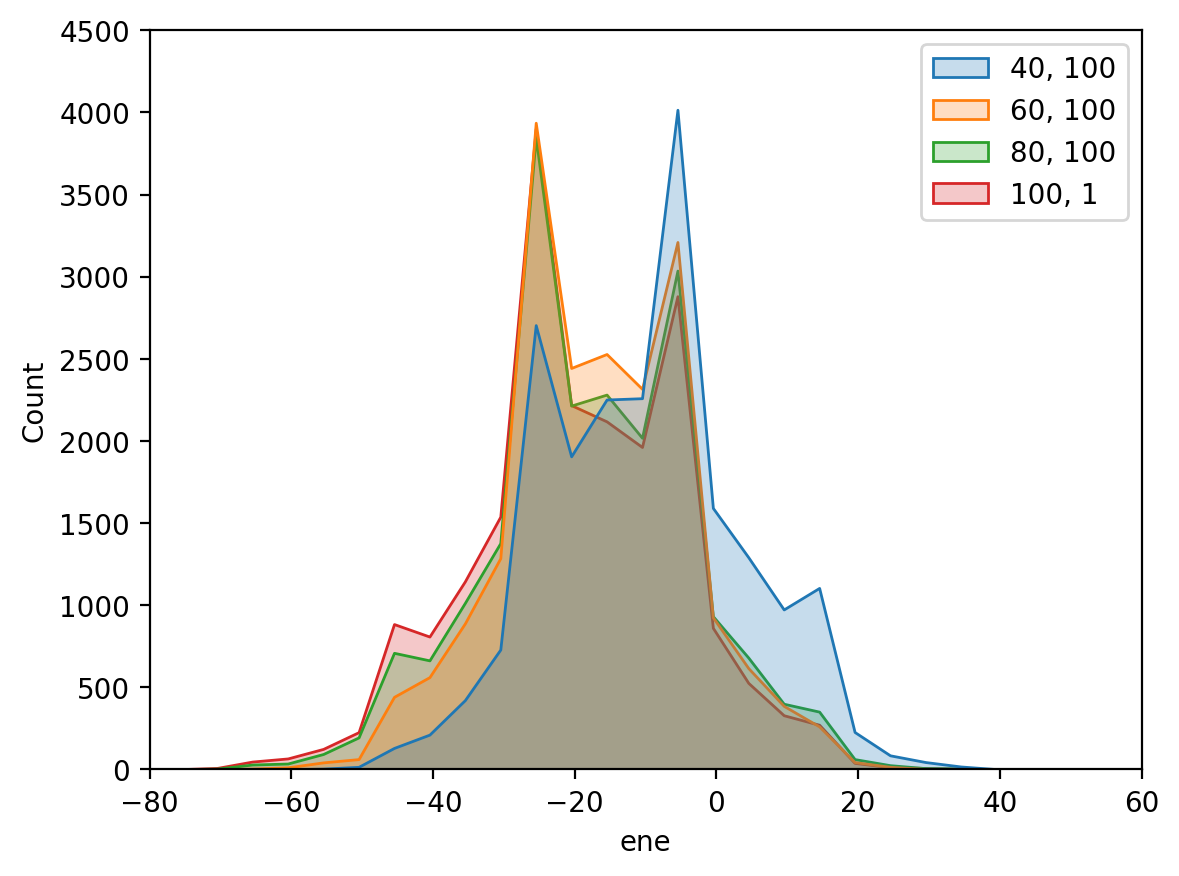

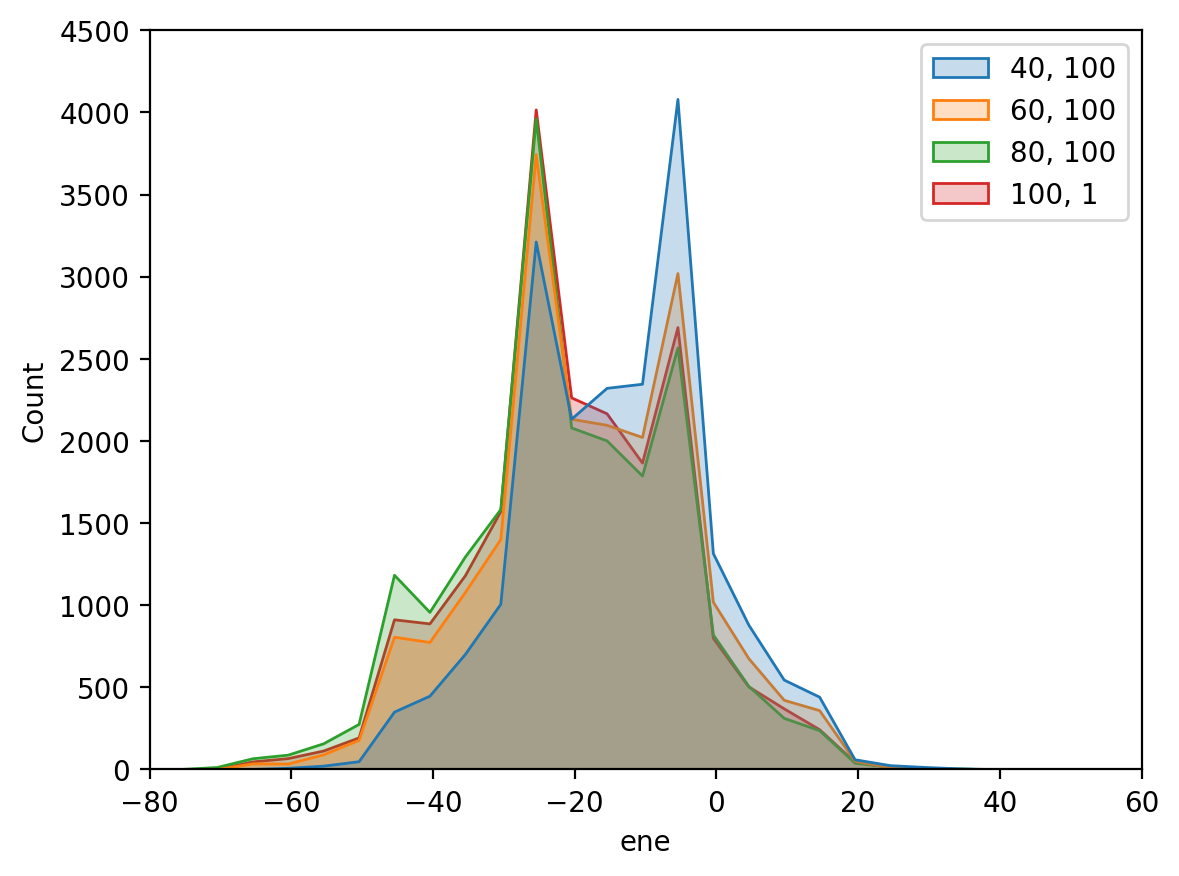

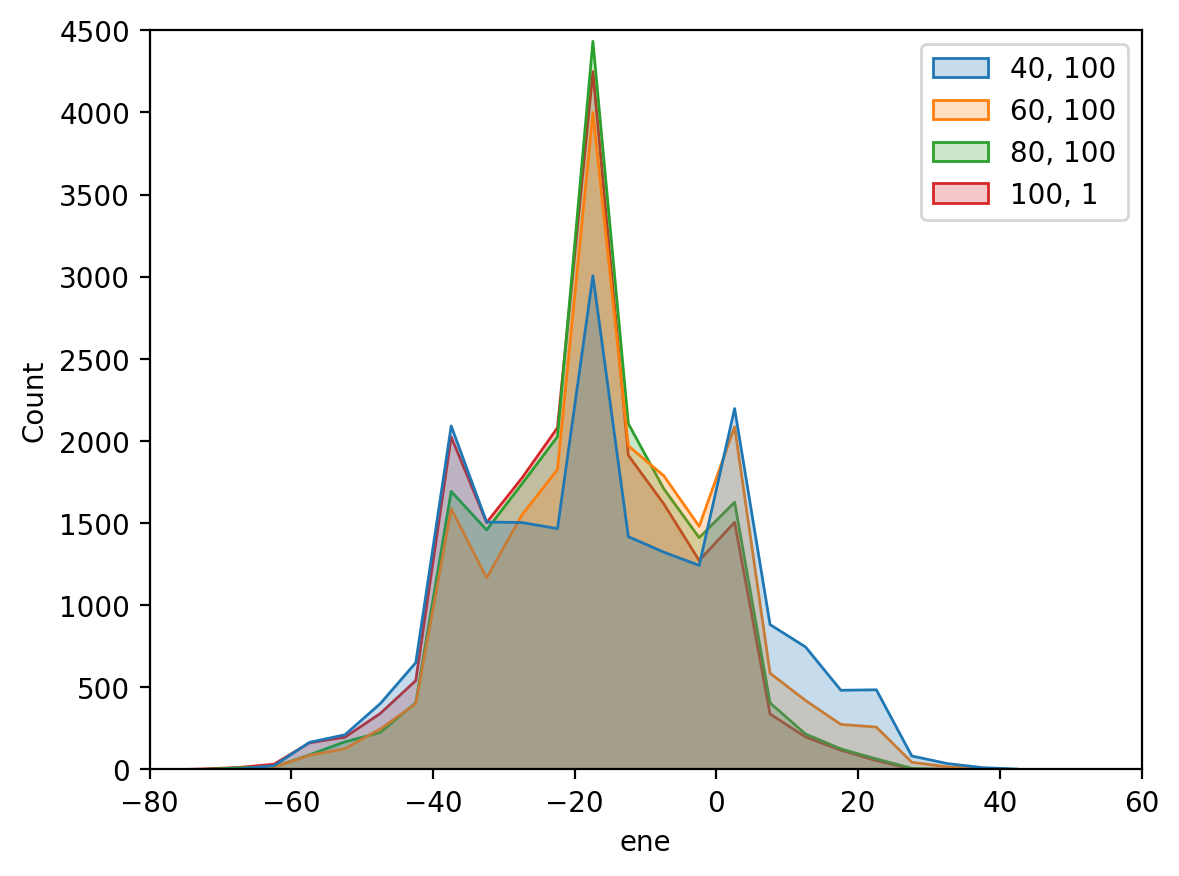

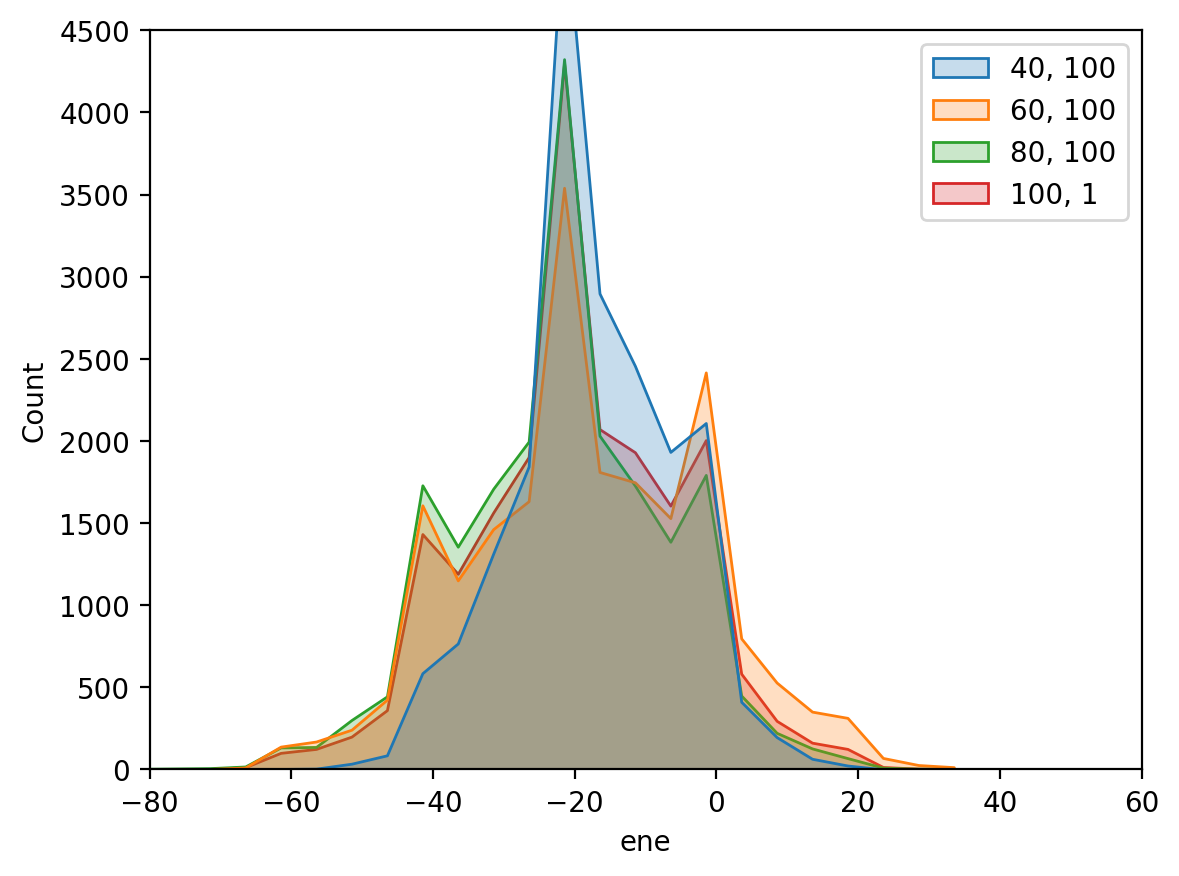

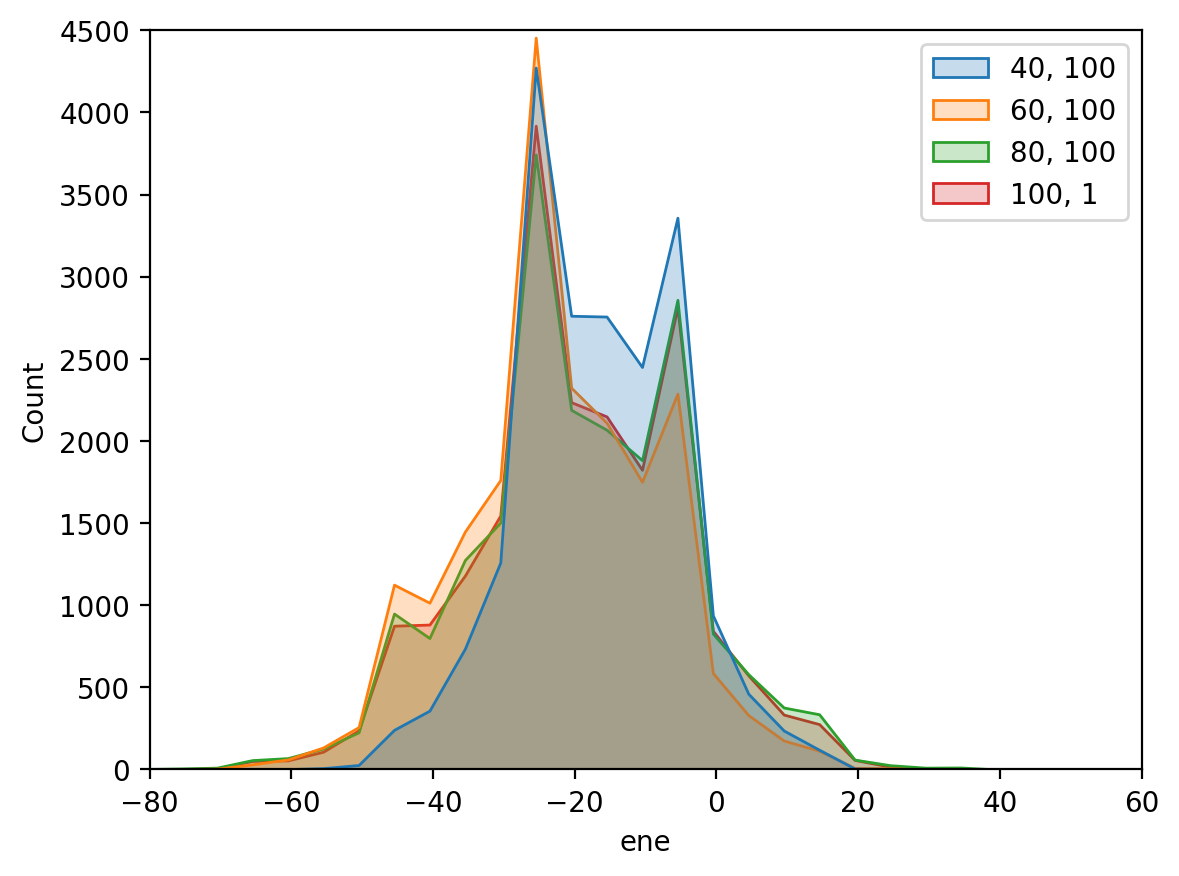

In [79]:
tuplist = [
    (1, 100),
    (5, 40),
    (100, 40),
    (5, 60),
    (100, 60),
    (5, 80),
    (100, 80)
]
# for ae, a in tuplist:
    # qdf = comp_df.query(f'`Active Epochs`=={ae} and Active=={a}')
# os.mkdir(f'ae_{ae}_a_{a}_distfigs')
maxep = comp_df['epoch'].max()
step = 20000
qdf = comp_df.query('`Active Epochs` == 100 or `Active Epochs` == 1')
hue = qdf['Active'].astype(str) + ', ' + qdf['Active Epochs'].astype(str)
for i in range(0, 100001-step, step):
    fig, ax = plt.subplots(dpi=200)
    lim_df = qdf.query(f'epoch >= {i} and epoch < {i+step}')
    sns.histplot(ax=ax,data=lim_df, x='ene', binwidth=5, hue=hue, element='poly')
    ax.set_xlim(-80, 60)
    ax.set_ylim(0, 4500)
    plt.show()
    
    # ax.set_title(f'2D Ising')



In [125]:
analysis_df = pd.concat([df40_5, df40_100,
                     df60_5, df60_100,
                     df80_5, df80_100,
                     df100], axis=1,
                     keys=['40_5', '40_100', '60_5', '60_100', '80_5', '80_100', '100'], 
                     )
bins = np.arange(-80, 60)
iterset = set(analysis_df.columns.get_level_values(0))
iterset.remove('100')
rmslist = []
for e in range(0, int(1e6+1)-step, step):
    dfref = analysis_df['100'].query(f'epoch >= {e} and epoch < {e+step}')
    distref = np.histogram(dfref['ene'], bins=bins)
    denom = distref[0]
    denom[denom == 0] = 1
    for i in iterset:
        dfi = analysis_df[i].query(f'epoch >= {e} and epoch < {e+step}')
        disti = np.histogram(dfi['ene'].to_list(), bins=bins)
        rms = np.mean(np.sqrt(np.power((distref[0]-disti[0])/denom, 2)) / len(disti))
        rmslist.append((e, e+step,i, rms))

In [126]:
errdf = pd.DataFrame.from_records(rmslist, columns=['epoch_start', 'epoch_end', 'active_active-epochs', 'energy_dist_rms'])

<Axes: xlabel='epoch_start', ylabel='energy_dist_rms'>

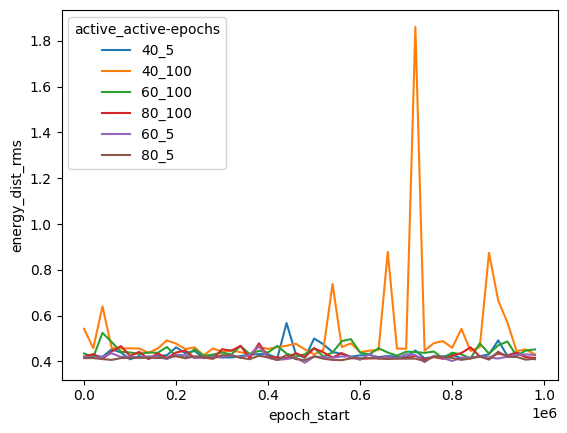

In [128]:
sns.lineplot(data=errdf, x='epoch_start', y='energy_dist_rms', hue='active_active-epochs')

In [35]:
activelist = [0, 50]
betalist = [0.1, 0.5, 0.9]
ae = [1, 5, 10]
burnin = 5000
fulldf = pd.concat([pd.concat([pd.read_csv(i).iloc[burnin:].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}/active_0_*')]) for b in betalist], keys=betalist, axis=1)
dfpartlist = dict([(b, dict([(ep, pd.concat([pd.read_csv(i).iloc[burnin:].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}/active_50_ae_{ae}*')])) for ep in ae]))
                            for b in betalist])

In [30]:
betalist = []
betadflist = []
for beta, bdict in dfpartlist.items():
    bdf = pd.concat([v for v in bdict.values()], keys=[k for k in bdict.keys()], axis=1)
    betalist.append(beta)
    betadflist.append(bdf)
partdf = pd.concat(betadflist, keys=betalist, axis=1)

In [42]:
bounds = dict([(beta, (np.min(partdf[beta][5]['ene']), np.max(partdf[beta][5]['ene']))) for beta in betalist])

In [58]:
for beta in [0.1, 0.5, 0.9]:
    print(np.sqrt(np.mean(fulldf[beta]['M'])), np.sqrt(np.mean(partdf[beta][1]['M'])), np.sqrt(np.mean(partdf[beta][5]['M'])), np.sqrt(np.mean(partdf[beta][10]['M'])))

0.12493167092454978 0.1253391144056794 0.1253391144056794 0.1253391144056794
0.9154704220235627 0.9163219362938627 0.9163219362938627 0.9163219362938627
0.9983405899791914 0.9982882020739301 0.9982882020739301 0.9982882020739301


In [78]:
b = 0.1
epochs = 1500
ep = 1
len(glob.glob(f'../beta_{b:.1f}_e{epochs}/active_50_ae_{ep}*'))

100

In [159]:
def get_sa_info(active, betalist, ae, burnin, epochs, maxepoch=-1):
    if maxepoch == -1:
        fulldf = pd.concat([pd.concat([pd.read_csv(i).iloc[burnin:].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}_e{epochs}/active_0_*')]) for b in betalist], keys=betalist, axis=1)
        dfpartlist = dict([(b, dict([(ep, pd.concat([pd.read_csv(i).iloc[burnin:].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}_e{epochs}/active_{active}_ae_{ep}_*')])) for ep in ae]))
                                    for b in betalist])
    else:
        fulldf = pd.concat([pd.concat([pd.read_csv(i).iloc[burnin:maxepoch].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}_e{epochs}/active_0_*')]) for b in betalist], keys=betalist, axis=1)
        dfpartlist = dict([(b, dict([(ep, pd.concat([pd.read_csv(i).iloc[burnin:maxepoch].reset_index(drop=True) for i in glob.glob(f'../beta_{b:.1f}_e{epochs}/active_{active}_ae_{ep}_*')])) for ep in ae]))
                                    for b in betalist])
    betalist = []
    betadflist = []
    for beta, bdict in dfpartlist.items():
        reference = fulldf[beta].copy()
        reference['active'] = 100
        dlist = []
        for k,v in bdict.items():
            v['active'] = 50
            v = pd.concat([v, reference])
            dlist.append(v)
        bdf = pd.concat(dlist, keys=[k for k in bdict.keys()], axis=1)
        betalist.append(beta)
        betadflist.append(bdf)
    partdf = pd.concat(betadflist, keys=betalist, axis=1)
    return fulldf, partdf


In [200]:
def plot_distributions(partdf:pd.DataFrame, min_epoch=None, max_epoch=None, outname=None):   
    bounds = dict([(beta, (np.min(partdf[beta][10]['ene']), np.max(partdf[beta][10]['ene']))) for beta in betalist])
    if min_epoch is None:
        min_epoch = 0
    if max_epoch is None:
        max_epoch = 1e10
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(17, 16), dpi=200)
    beta = list(set(partdf.columns.get_level_values(0)))
    beta = sorted(beta)
    active_epochs = list(set(partdf.columns.get_level_values(1)))
    active_epochs = sorted(active_epochs)
    for beta, axlist in zip(beta, axs):
        for ax, ep in zip(axlist, active_epochs):
            lim_df = partdf[beta][ep].query(f'epoch >= {min_epoch} and epoch < {max_epoch}')
            sns.histplot(ax=ax, data=lim_df, x='ene',hue='active',element='step', binwidth=2, palette=sns.color_palette('tab10', 2))
            ax.set_xlim(bounds[beta])
            ax.set_yscale('log' if beta == 0.9 else 'linear')
            ax.set_title('Beta {}, TSwap {}'.format(beta, ep), fontsize=18)
            ax.set_xlabel('Energy')
    fig.suptitle(f'Epochs: {min_epoch}-{max_epoch}', y=0.93, fontsize=24)
    plt.close()
    if outname is not None:
        fig.savefig(outname, dpi=200)
# plot_distributions(part_1500)

In [201]:
full_15000, part_15000 = get_sa_info(50, [0.1, 0.5, 0.9], [1,5,10], 0, 15000)
# full_1500, part_1500 = get_sa_info(50, [0.1, 0.5, 0.9], [1,5,10], 500, 15000, 1500)
# full_150, part_150 = get_sa_info(50, [0.1, 0.5, 0.9], [1,5,10], 50, 15000, 150)

for i in range(0, 5000, 100):
    print(i, i+100)
    plot_distributions(part_15000, i, i+100, f'../window_figures/epoch_window_{i}_{i+100}.png')



0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100
1100 1200
1200 1300
1300 1400
1400 1500
1500 1600
1600 1700
1700 1800
1800 1900
1900 2000
2000 2100
2100 2200
2200 2300
2300 2400
2400 2500
2500 2600
2600 2700
2700 2800
2800 2900
2900 3000
3000 3100
3100 3200
3200 3300
3300 3400
3400 3500
3500 3600
3600 3700
3700 3800
3800 3900
3900 4000
4000 4100
4100 4200
4200 4300
4300 4400
4400 4500
4500 4600
4600 4700
4700 4800
4800 4900
4900 5000


In [204]:
def get_rmse(partdf:pd.DataFrame, min_epoch=None, max_epoch=None):  
    bounds = dict([(beta, (np.min(partdf[beta][10]['ene']), np.max(partdf[beta][10]['ene']))) for beta in betalist])
    if min_epoch is None:
        min_epoch = 0
    if max_epoch is None:
        max_epoch = 1e10
    beta = list(set(partdf.columns.get_level_values(0)))
    beta = sorted(beta)
    active_epochs = list(set(partdf.columns.get_level_values(1)))
    active_epochs = sorted(active_epochs)
    result_list = []
    for b in beta:
        bins = np.arange(bounds[b][0], bounds[b][1], 2)
        for ep in active_epochs:
            lim_df = partdf[b][ep].query(f'epoch >= {min_epoch} and epoch < {max_epoch}')
            reflim_df = lim_df.query('active==100')
            complim_df = lim_df.query('active==50')
            refhist = np.histogram(reflim_df['ene'], bins=bins)
            comphist = np.histogram(complim_df['ene'], bins=bins)
            rmse = np.sqrt(np.mean(
                np.power( (comphist - refhist) )))
            result_list.append((b, ep, min_epoch, max_epoch,  rmse))
    return pd.DataFrame.from_records(result_list, columns=['beta', 'tswap', 'min_epoch', 'max_epoch', 'RMSE'])

In [205]:
dflist = []
for i in range(0, 5000, 100):
    dflist.append(get_rmse(part_15000, i, i+100))
rmsedf = pd.concat([dflist])

TypeError: cannot unpack non-iterable float object

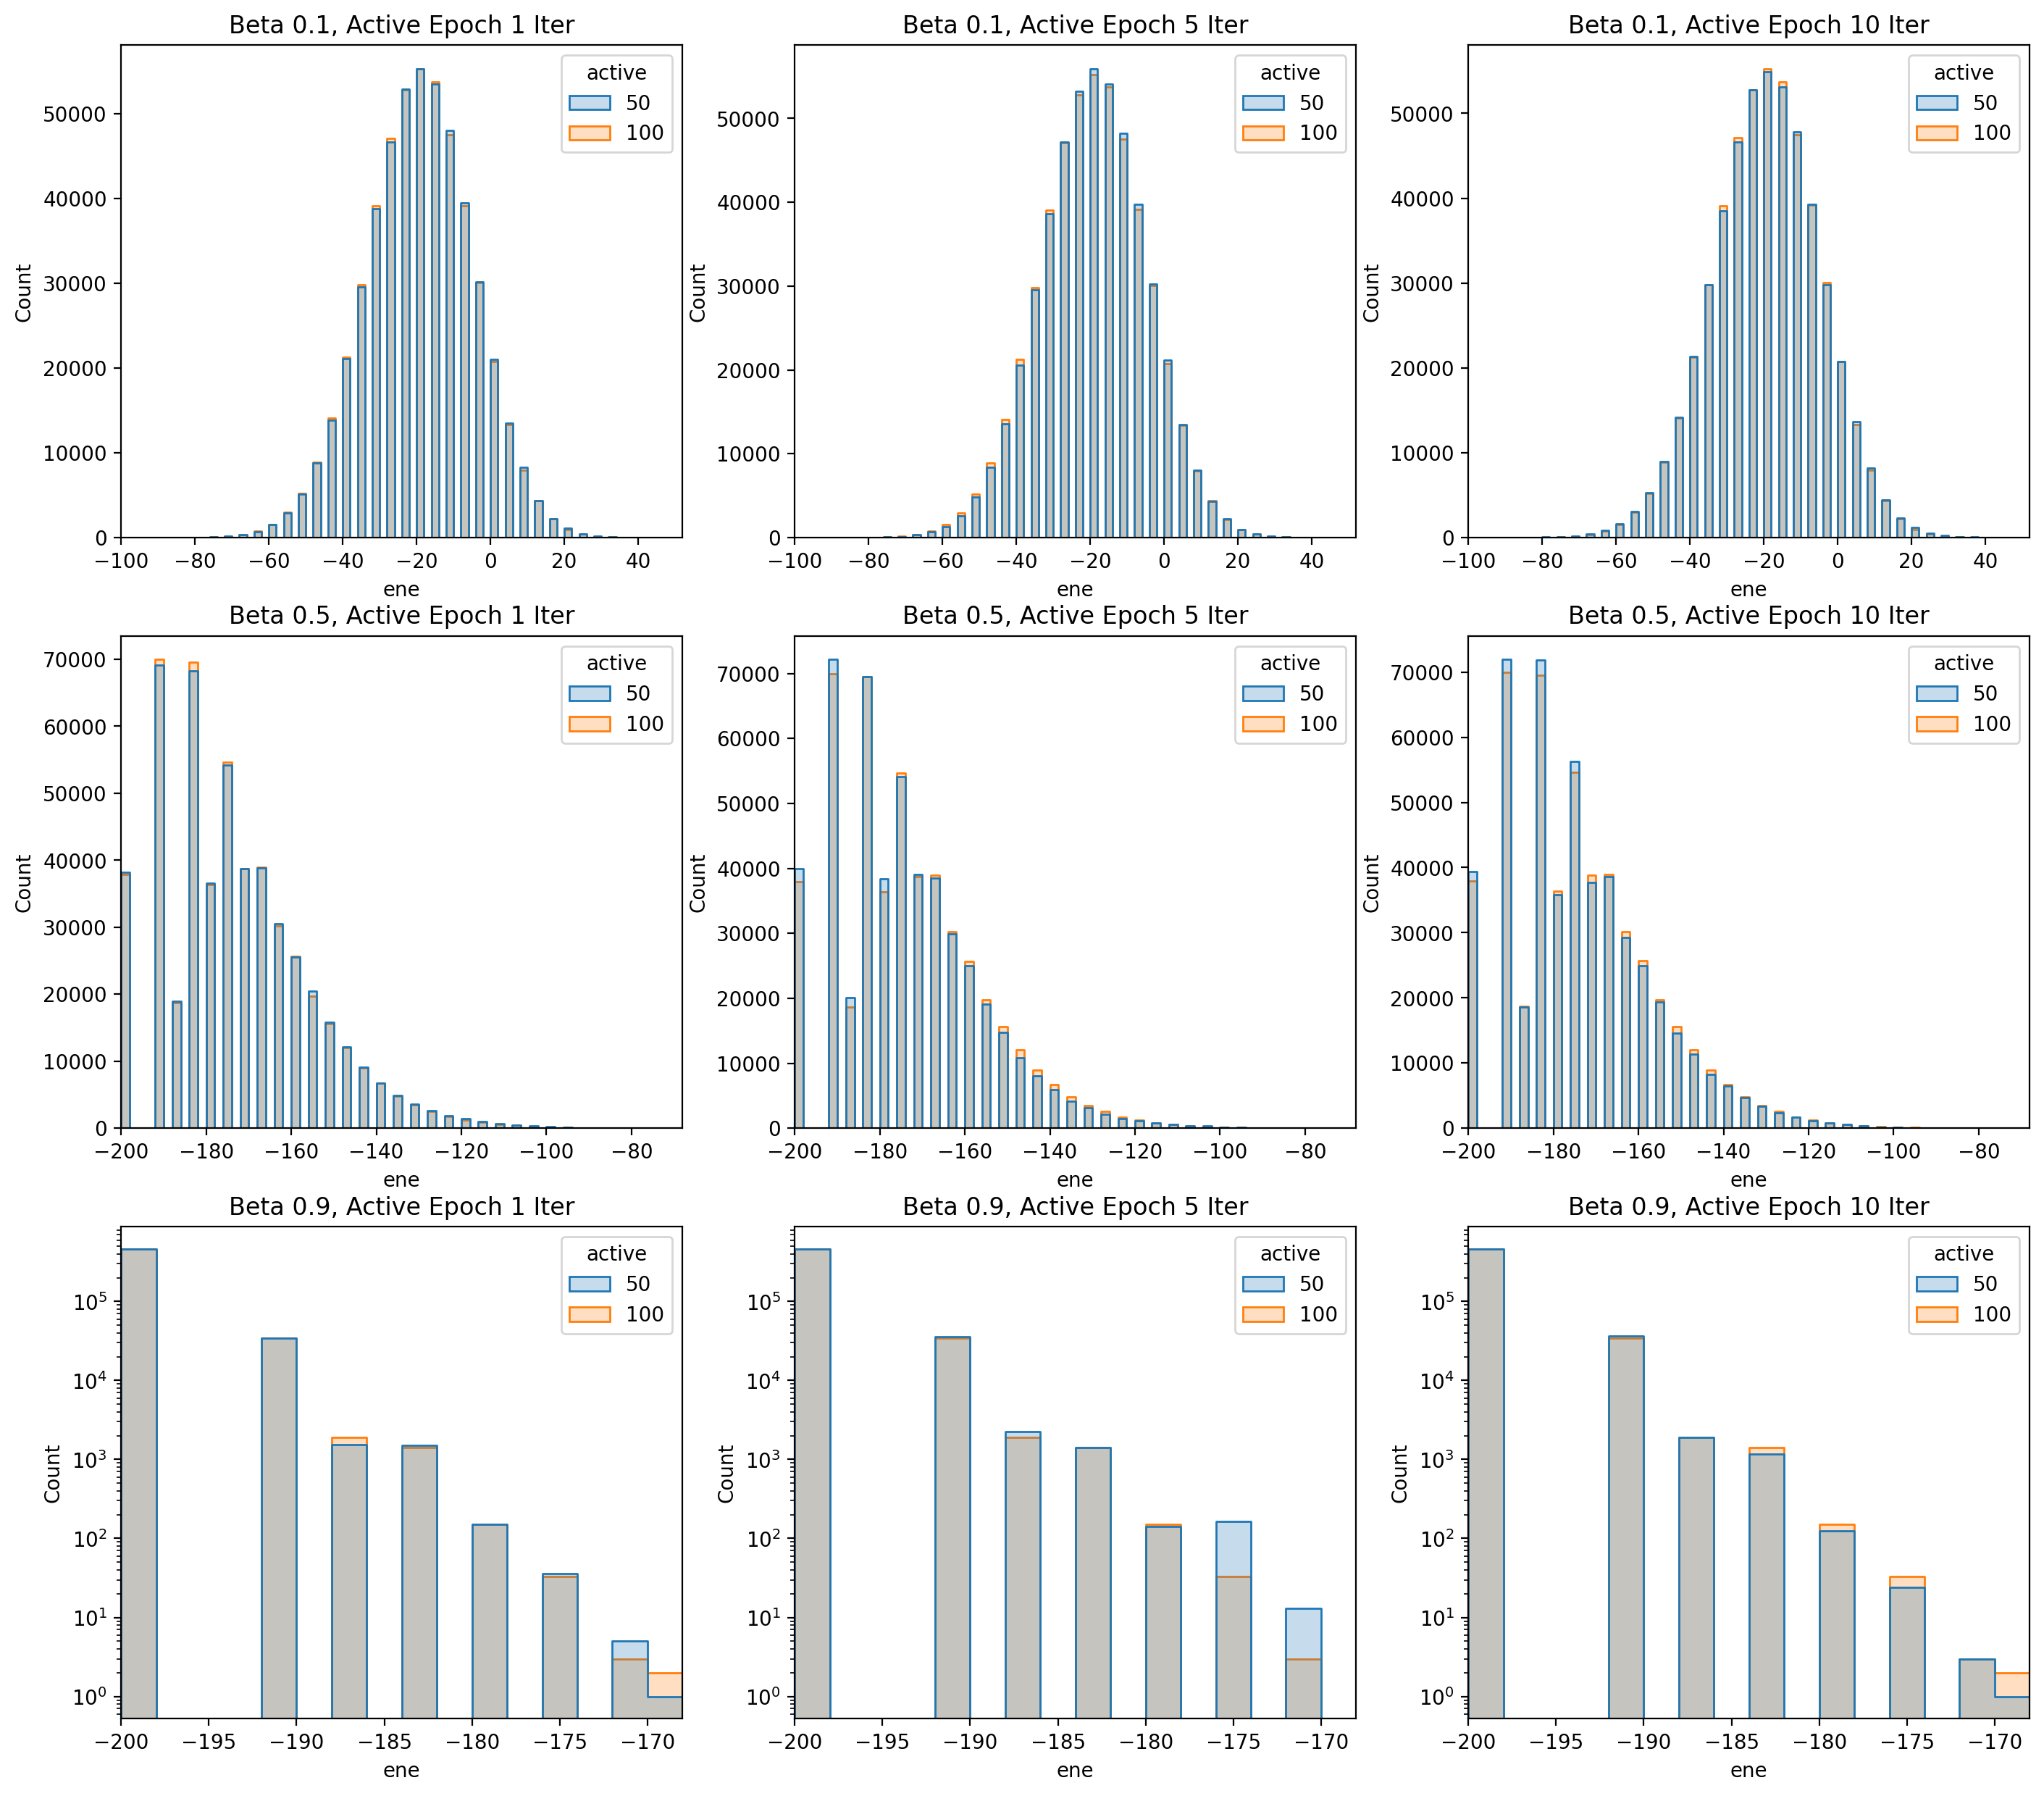

In [150]:
plot_distributions(part_15000)

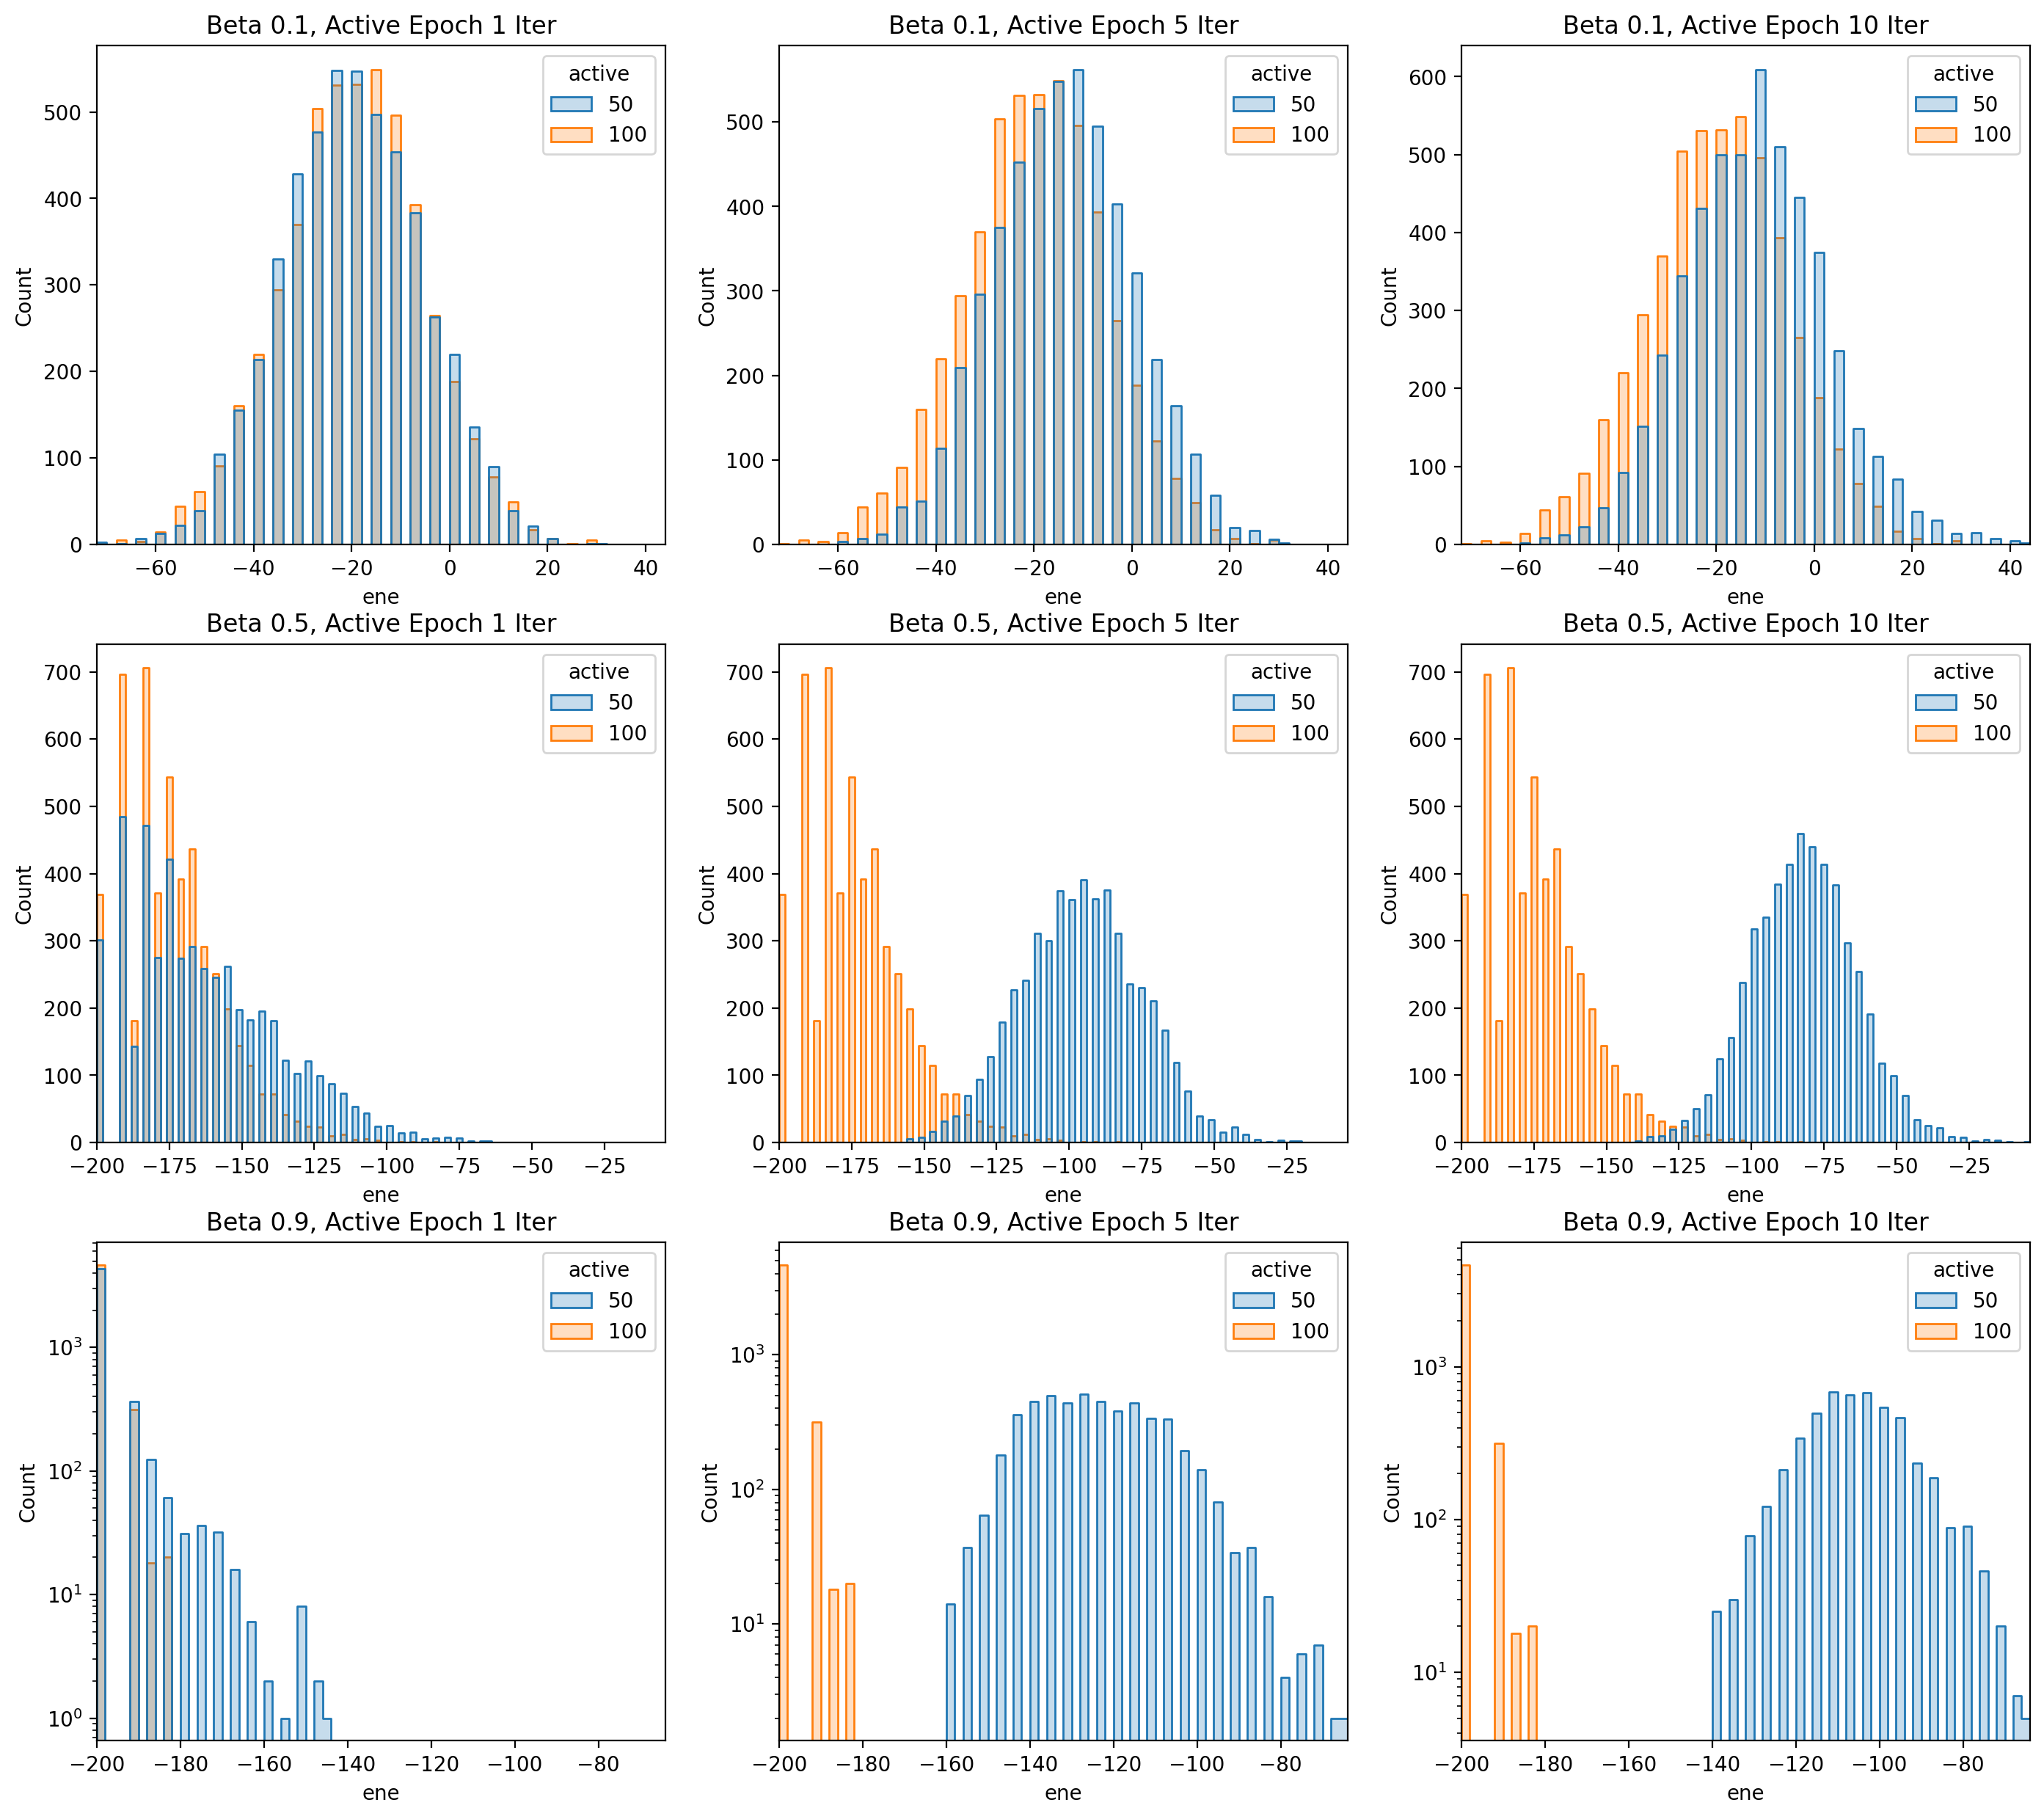

In [151]:
plot_distributions(part_150)

In [114]:
for beta in [0.1, 0.5, 0.9]:
    print(np.sqrt(np.mean(fulldf[beta]['M'])), np.sqrt(np.mean(partdf[beta][1]['M'])), np.sqrt(np.mean(partdf[beta][5]['M'])), np.sqrt(np.mean(partdf[beta][10]['M'])))

0.12490504200087912 0.12537842084582615 0.12483451335323065 0.1252855089729881
0.915327763869503 0.9148815457525746 0.9163402786120975 0.9132690721079771
0.9983388470440492 0.998346515477225 0.99827257006187 0.9983424603501201


In [115]:
for beta in [0.1, 0.5, 0.9]:
    print(np.sqrt(np.mean(fulldf[beta]['M'])), np.sqrt(np.mean(partdf[beta][1]['M'])), np.sqrt(np.mean(partdf[beta][5]['M'])), np.sqrt(np.mean(partdf[beta][10]['M'])))

0.12490504200087912 0.12537842084582615 0.12483451335323065 0.1252855089729881
0.915327763869503 0.9148815457525746 0.9163402786120975 0.9132690721079771
0.9983388470440492 0.998346515477225 0.99827257006187 0.9983424603501201
